In [1]:
%load_ext lab_black

In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

$$
\begin{array}{ll}
\mbox{minimize} & f_0(x_1,x_2) \\
\mbox{subject to} & 2x_1+x_2 \geq 1 \\
          & x_1 +3x_2 \geq 1 \\
          & x_1 \geq 0, \quad x_2\geq 0.
\end{array}
$$

## Question 2

In [3]:
# Define and solve the CVXPY problem.
x1 = cp.Variable()
x2 = cp.Variable()

constraints = [2 * x1 + x2 >= 1, x1 + 3 * x2 >= 1, x1 >= 0, x2 >= 0]

### Part 1
$
f_0(x_1,x_2) = x_1+x_2
$

In [4]:
obj = cp.Minimize(x1 + x2)
prob = cp.Problem(obj, constraints)
prob.solve()

0.5999999999116253

### Part 
$
f_0(x_1,x_2) = x_1^2 + 9x_2^2
$

In [5]:
obj = cp.Minimize(x1 ** 2 + 9 * x2 ** 2)
prob = cp.Problem(obj, constraints)
prob.solve()

0.5000000000000003

## Question 3
### Boolean LP
$$
\begin{array}{ll}\mbox{minimize} & c^Tx \\ \mbox{subject to} & Ax \preceq b\\ & x_i \in \{0,1\}, \quad i=1, \ldots, n, \end{array}
$$

### Relax LP
$$
\begin{array}{ll} \mbox{minimize} & c^Tx \\\mbox{subject to} & Ax \preceq b\\ & 0 \preceq  x \preceq \mathbf{1},\end{array}
$$

In [6]:
def read_matrix(filename, sep=","):
    matrix = []
    with open(filename, "r") as file:
        for line in file.readlines():
            row = [float(x) for x in line.split(sep)]
            matrix.append(row)
    return np.matrix(matrix)

In [7]:
A = read_matrix("A.txt")

In [8]:
len(A), len(A[0])

(300, 1)

In [9]:
A.shape

(300, 100)

In [10]:
A[:5, :5]

matrix([[0.95012929, 0.36031117, 0.89520169, 0.0271904 , 0.07691701],
        [0.23113851, 0.54851281, 0.94238725, 0.79366702, 0.72091503],
        [0.60684258, 0.26176957, 0.33508338, 0.99923075, 0.76491151],
        [0.48598247, 0.59734485, 0.43736382, 0.11023852, 0.65794492],
        [0.89129897, 0.049278  , 0.47115591, 0.62260116, 0.81040852]])

In [11]:
n = 100
m = 300
A = read_matrix("A.txt")
c = read_matrix("c.txt")

# A = np.random.rand(m, n)
# A = A.reshape(m,n)
b = A @ np.ones((n, 1)) / 2
# c = -np.random.rand(n, 1)

In [12]:
c.shape

(100, 1)

In [13]:
x = cp.Variable((n, 1))
constraints = [A @ x <= b, x >= np.zeros((n, 1)), x <= np.ones((n, 1))]
obj = cp.Minimize(c.transpose() @ x)
prob = cp.Problem(obj, constraints)
L = prob.solve()
L

-33.16723960901254

In [14]:
# x.value

In [15]:
ts = np.linspace(0, 1, 100)
x_hats = []
U = []
max_violations = []
for t in ts:
    x_hat = 1 * (x.value >= t)
    x_hats.append(x_hat)
    U.append(float(c.transpose() @ x_hat))
    max_violations.append(float(max(A * x_hat - b)))

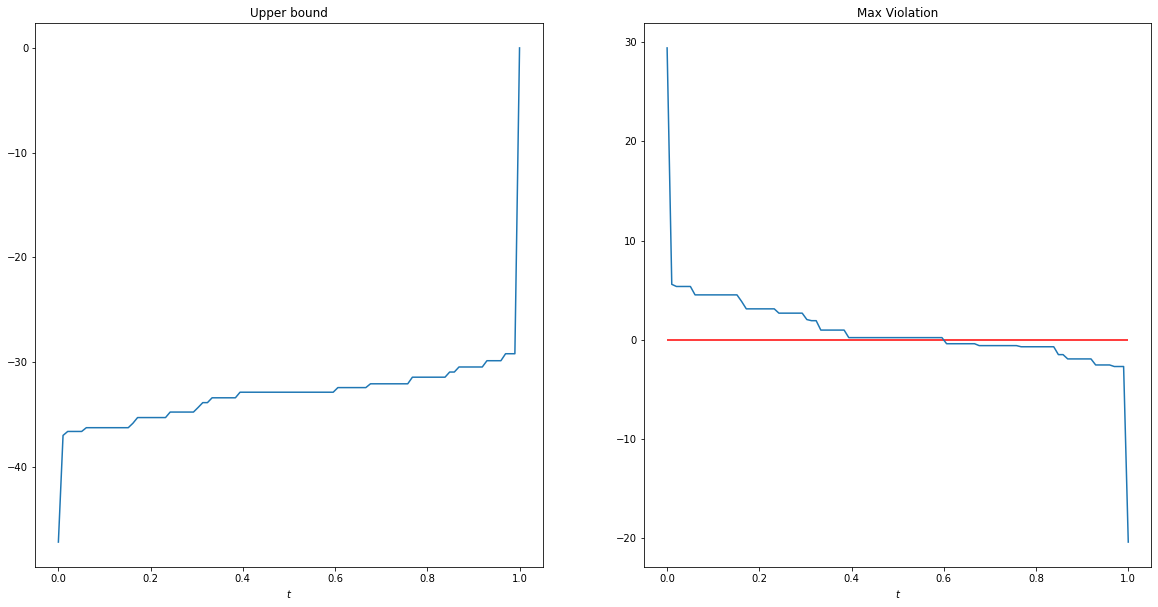

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
ax.plot(ts, U)
ax.set_title("Upper bound")

ax = axes[1]
ax.plot(ts, max_violations)
ax.hlines(0, 0, 1, color="r")
ax.set_title("Max Violation")

for ax in axes:
    ax.set_xlabel("$t$")

In [17]:
U_star = min(obj for obj, maxviol in zip(U, max_violations) if maxviol <= 0)
U_star

-32.4450307431

In [18]:
U_star - L

0.7222088659125419

## Question 4
We consider a portfolio optimization problem as described on pages 155 and 185–186 of the book, with data that can be found in the file simple_portfolio_data.m.

Find minimum-risk portfolios with the same expected return as the uniform portfolio  𝑥=(1/𝑛)1 , with risk measured by portfolio return standard deviation, and the following portfolio constraints (in addition to  1𝑇𝑥=1 ).

In [19]:
S = read_matrix("S.txt")
pbar = read_matrix("pbar.txt")
n = pbar.shape[0]
x_unif = np.ones((n, 1)) / n

### Part a
What is the risk of the uniform portfolio?

In [20]:
r_unif = float(pbar.T @ x_unif)
vol_unif = np.sqrt(float(x_unif.T @ S @ x_unif))
print(vol_unif)
print(f"r = {r_unif:0.1%}, sigma = {vol_unif:0.1%}")

0.08703595741224256
r = 9.9%, sigma = 8.7%


What is the risk of an optimal portfolio with no (additional) constraints?

In [21]:
x = cp.Variable(n)
constraints = [pbar.T @ x >= r_unif, np.ones((1, n)) @ x == 1]
obj = cp.Minimize(cp.quad_form(x, S))

In [22]:
prob = cp.Problem(obj, constraints)
optimal_sig = np.sqrt(prob.solve())
optimal_sig

0.018607150257670266

What is the risk of a long-only portfolio  𝑥⪰0 ?

In [23]:
constraints = [pbar.T @ x >= r_unif, np.ones((1, n)) @ x == 1, x >= 0]

In [24]:
prob = cp.Problem(obj, constraints)
optimal_sig = np.sqrt(prob.solve())
optimal_sig

0.05065821797569153

What is the risk of a portfolio with a limit on total short position:  1𝑇(𝑥−)≤0.5 , where  (𝑥−)𝑖=max{−𝑥𝑖,0} ?

In [25]:
x_plus = cp.Variable(n)
x_neg = cp.Variable(n)
x = x_plus - x_neg
constraints = [
    pbar.T @ x >= r_unif,
    np.ones((1, n)) @ x == 1,
    x_plus >= 0,
    x_neg >= 0,
    cp.sum(x_neg) <= 0.5,
]
obj = cp.Minimize(cp.quad_form(x, S))

In [26]:
prob = cp.Problem(obj, constraints)
optimal_sig = np.sqrt(prob.solve())
optimal_sig

0.020994685491867778

In [27]:
x_neg.value

array([9.29156151e-02, 4.48411943e-20, 4.55709027e-20, 2.51124115e-02,
       4.19763437e-20, 5.03397557e-20, 5.09181111e-20, 5.06315601e-20,
       4.99824292e-20, 4.66216698e-20, 1.02742502e-01, 5.14486553e-20,
       4.17897393e-20, 4.44254768e-20, 3.26855153e-02, 4.01060910e-02,
       2.06437866e-01, 6.93387092e-20, 4.43604030e-20, 5.96813464e-20])